In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import gc; gc.enable()

from utilities import DfLowMemory

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import WOEEncoder, TargetEncoder
from xgboost import XGBClassifier
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = DfLowMemory('train_ver2.csv')

In [3]:
# ind_empleado - 27734. Employee index: A active, B ex employed, F filial, N not employee, P pasive. 
#I am noticing that there is a value that is not in the description so I believe it is a typo. 
#I tried looking more into the data but in the end I decided to drop since it is just one person.

df = df[df['ind_empleado'] != 'S']

In [4]:
# pais_residencia - 27734. One aspect that I found interesting is that customers with pais_residenciamissing had all other features missing. 
#For now I am going to drop all of them

df.dropna(subset=['pais_residencia'], inplace=True)

In [5]:
# Now there are 70 missing values for gender. The value distribution doesn't seem very different. I am going to replace them with the mode.
df['sexo'].fillna(df['sexo'].mode()[0], inplace=True)

In [6]:
# ult_fec_cli_1t has a lot of missing values. This represents the last day the the customer was the primary costumer.
# Looking at the indrel_1mes column, it shows that most of the customers at the beginning of the month were the primary costumers. So 
# I am assuming that the customers with missing last date as the primary costumers are still the primary costumers. So I am going to impute 
# this with 'primary'
# THIS NEEDS TO BE MODIFIED TO TYPE DATE
df.loc[df['ult_fec_cli_1t'].isnull(), 'ult_fec_cli_1t'] = 'PRIMARY'

In [7]:
# Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner).
# some values that were supposed to be 1 are 1.0 and for the other categories as well. So I am going to use 1,2,3,4 like in the description
# This has been suggested by @StephenSmith
map_dict = {'1.0' : '1',
            '1' : '1',
            '2' : '2',
            '2.0' : '2',
            '3' : '3',
            '3.0' : '3', 
            '4' : '4',
            '4.0' : '4'}

df.indrel_1mes.fillna('P', inplace=True)
df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df.indrel_1mes = df.indrel_1mes.astype('category')

In [8]:
# Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)
# There are some described as N that doesn't fit into the column description.
# Taking a closer look at these 4 rows and comparing them with the ind_actividad: df[df['tiprel_1mes'] == 'N'].iloc[:,8:24]
# The ones that had ind_actividad = 1 were imputed as active and the ones that had 0 were imputed as I
# For the nan values, there is another column named 'ind_actividad_cliente' that is 1 for active costumers and 0 for inactive. I am 
# going to use this to impute the nan values for tiprel_1mes

df.loc[df['tiprel_1mes'].isnull(), 'tiprel_1mes'] = df['ind_actividad_cliente']

map_tip = {1 : 'A',
           0 : 'I'}        

df.tiprel_1mes = df.tiprel_1mes.apply(lambda x: map_tip.get(x,x))
df.loc[6603017, 'tiprel_1mes'] = 'A'
df.loc[10123924, 'tiprel_1mes'] = 'A'
df.loc[10124648, 'tiprel_1mes'] = 'I'
df.loc[11247349, 'tiprel_1mes'] = 'I'

df.tiprel_1mes = df.tiprel_1mes.astype('category')

In [9]:
# conyuemp Spouse index. 1 if the customer is spouse of an employee
# I am assuming that most customers are not spouses and I am going to impute these with the mode
# Now there are 70 missing values for gender. The value distribution doesn't seem very different. I am going to replace them with the mode.
df['conyuemp'].fillna(df['conyuemp'].mode()[0], inplace=True)
df.conyuemp = df.conyuemp.astype('category')

In [10]:
# canal_entrada. Channel used by the customer to join
# I am going to fill the missing values with the mode
df['canal_entrada'].fillna(df['canal_entrada'].mode()[0], inplace=True)

In [11]:
# tipodom. Addres type. 1, primary address. It is only 1 value missing so I am just going to replace it with the mode
df['tipodom'].fillna(df['tipodom'].mode()[0], inplace=True)

In [12]:
# cod_prov. Province code (customer's address)
# nomprov. Province name. 
# These two have the same number of missing values. I am going to replace these with unknow
# THESE IS SUGGESTED BY ALAN PRYOR

for c in ['cod_prov', 'nomprov']:
    df.loc[df[c].isnull(), c ] = 'UNKOWN'

In [13]:
# Renta. Gross income of the household. I am going to replace the missing values with the mean salary per providence. 

salaries = dict(df.groupby('nomprov')['renta'].mean().round(0))
df.loc[df['renta'].isnull(), 'renta'] = df['nomprov']
df.renta = df.renta.apply(lambda x: salaries.get(x,x))

In [14]:
# Segmento. segmentation: 01 - VIP, 02 - Individuals 03 - college graduated
for c in ['segmento']:
    df.loc[df[c].isnull(), c ] = 'UNKOWN'

In [15]:
df['ind_nomina_ult1'].fillna(df['ind_nomina_ult1'].mode()[0], inplace=True)

In [16]:
df['ind_nom_pens_ult1'].fillna(df['ind_nom_pens_ult1'].mode()[0], inplace=True)

In [ ]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'], format="%Y-%m-%d")
df['fecha_alta'] = pd.to_datetime(df['fecha_alta'], format="%Y-%m-%d")

In [17]:
df.loc[df['antiguedad'] == '-999999', 'antiguedad'] = 'UNKNOWN'

In [18]:
df['fecha_dato'].unique()

array(['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28',
       '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28',
       '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28',
       '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28'], dtype=object)

# Missing values and action plan

ind_empleado - 27734. Employee index: A active, B ex employed, F filial, N not employee, P pasive. I am noticing that there is a value that is not in the description so I believe it is a typo. I tried looking more into the data but in the end I decided to drop since it is just one person. The nan values I am replacing with the mode which in this case it is that the person is not an employee.

df = df[df['ind_empleado'] != 'S']

-------------------------------------------------------
pais_residencia - 27734. One aspect that I found interesting is that customers with pais_residenciamissing had all other features missing. For now I am going to drop all of them

filtered_df = df[df['pais_residencia'].isnull()]
len(filtered_df['ncodpers'].unique())
This shows that there are 7340 without much information about them

-------------------------------------------------------
sexo - 27804. Most of the clients that have this information missing dont have much information on them overall. If we were to drop the ones that have most information missing, sexo would have about 70 values missing. For now I am going to change these with the mode.

-------------------------------------------------------
I need to turn fecha_dato and fecha_alta into dates

fecha_alta - 27734. This is the date that the customer joined the bank.
Added another column called month. May be useful in the case that some customers buy more depending on the time of the year.

-------------------------------------------------------
ult_fec_cli_1t - 13622516. This is the last date as a primary customer.
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_nomina_ult1             16063
ind_nom_pens_ult1           16063


-------------------------------------------------------
A bank guarantee is a lending institution's promise to cover a loss if a borrower (their customer) defaults on a debt to a third party. 

A payroll account is a separate bank account for your business that is strictly used for payroll. Instead of lumping all your business expenses into one account, you will pay employee wages with your payroll bank account. The money going into the payroll account will only be used for payroll.

Bank policy requires that account owners be the legal age of 18 in order to open an account online. If you are not 18 years old, you may open an account for minors with your parent or legal guardian as the joint account holder.

A pension plan is a type of retirement plan where an employee adds money into a fund that includes contributions by the employer.

A securities account sometimes known as a brokerage account is an account that holds financial assets such as securities on behalf of an investor with a bank, broker or custodian.

In [19]:
used_cols = [c for c in df.columns.tolist() if c not in ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']]

## Feature Engineering

In [ ]:
# Like 1st place solution mentioned, some features worth exploring are lags of products time since presence of products, average of products, time since last purchase
# of products
# time since change and lads for a non-product attributes: segmento, indactividadclient, codprov, canalentrada, indrel1mes, tiprel1mes

In [20]:
frames = []
for dato in df['fecha_dato'].unique().tolist():
    # get 10% sample for each day
    df_dato = df.loc[df['fecha_dato'] == dato].copy().sample(frac=0.10)

    # add to frames list
    frames.append(df_dato)
    gc.collect()


In [21]:
trial = pd.concat(frames)

In [25]:
trial['fecha_dato'] = pd.to_datetime(trial['fecha_dato'], format="%Y-%m-%d")
trial['fecha_alta'] = pd.to_datetime(trial['fecha_alta'], format="%Y-%m-%d")

In [27]:
trial.head(2)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
510166,2015-01-28,831676,N,ES,V,43,2009-02-03,0.0,77,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
547568,2015-01-28,473991,N,ES,V,69,2004-05-13,0.0,134,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


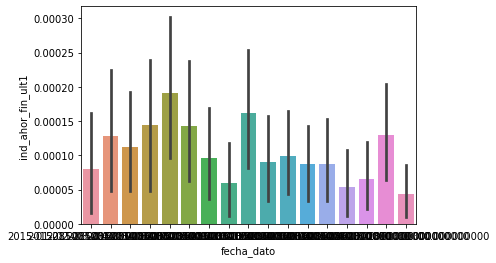

In [26]:
sns.barplot(x= trial['fecha_dato'], y=trial['ind_ahor_fin_ult1'])

In [76]:
trial['month'] = trial['fecha_dato'].dt.month

In [79]:
trial['YearMonth'] = trial['fecha_dato'].map(lambda x: 100*x.year + x.month)

In [83]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'], format="%Y-%m-%d")
df['fecha_alta'] = pd.to_datetime(df['fecha_alta'], format="%Y-%m-%d")

In [84]:
df['YearMonth'] = df['fecha_dato'].map(lambda x: 100*x.year + x.month)

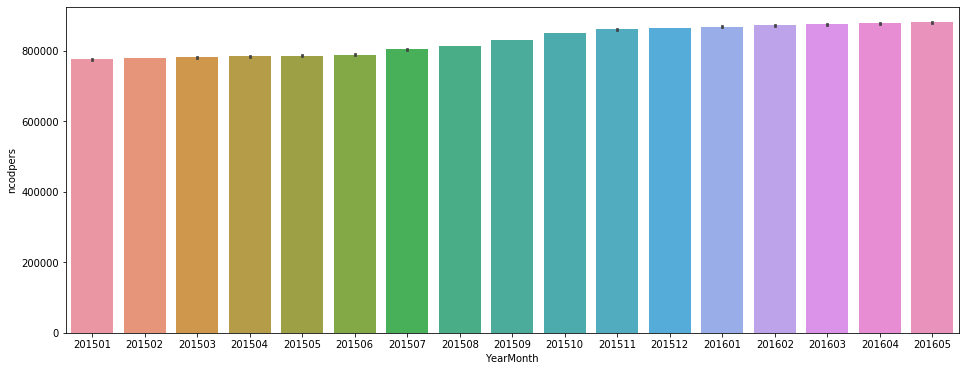

In [85]:
plt.figure(figsize=(16, 6))
sns.barplot(x= df['YearMonth'], y = df['ncodpers'])

In [93]:
trial['JoinYear'] = trial['fecha_alta'].apply(lambda x: 100*x.year + x.month)

In [94]:
d = trial.groupby('ncodpers')

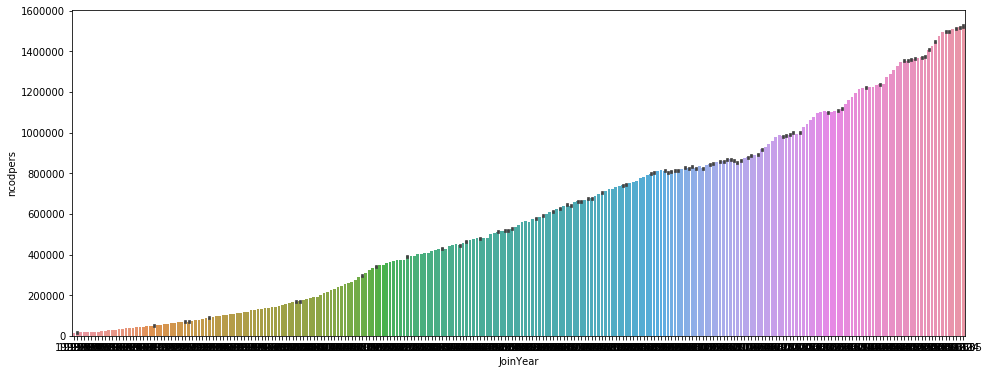

In [87]:
plt.figure(figsize=(16, 6))
sns.barplot(x= df['JoinYear'], y = df['ncodpers'])

In [122]:
new_customer = list(set(trial['ncodpers']))

In [119]:
new_cust_join_date = []

In [123]:
for customer in new_customer:
    new_customer_join_date.append(trial['fecha_alta'])

## Building a recommendation system

For a recommendation system first we need a distance metric so that we can find users who are similar to a given user.

In [38]:
target = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

In [39]:
used_cols = [c for c in trial.columns.tolist() if c not in [target, 'fecha_dato', 'fecha_alta']]

In [54]:
X = trial[used_cols].values
y = trial[target]

In [55]:
encoder = TargetEncoder()

for c in trial[ohe]:
    print(c)
    print(trial[c].unique())
    print('\n')

for t in target:
    X = trial[used_cols]
    y = trial[t]
    
    encoder = TargetEncoder()
    X = encoder.fit_transform(X,y)
    
    model = X
    

In [56]:
X = trial[used_cols].values
y = trial['ind_ahor_fin_ult1']

In [57]:
X = encoder.fit_transform(X,y)

In [59]:
# train test split

train_size = int(len(X) * 0.7)
y_train = int(len(y) * 0.7)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]
print('Observations: ', (len(X)))
print('Training Observations: ', (len(train)))
print('Testing Observations: ', (len(test)))

Observations:  1361956
Training Observations:  953369
Testing Observations:  408587


In [60]:
model = imb_xgb(special_objective='weighted', imbalance_alpha=2)

In [62]:
model.fit(X_train.values, y_train.values)

In [63]:
y_pred = model.predict(X_test.values)

In [64]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

In [136]:
len(y_pred)

408587

In [140]:
y_pred.astype(int)

array([-3, -3, -3, ..., -3, -3, -3])

In [151]:
(y_pred == y_pred[0]).all()

False

In [152]:
y_pred

array([-3.6116552, -3.6116552, -3.6116552, ..., -3.6116552, -3.6116552,
       -3.6116552], dtype=float32)

In [157]:
y_pred = (y_pred - y_pred.min())/(y_pred.max() - y_pred.min())

y_pred.min(), y_pred.max()

(0.0, 1.0)

In [170]:
### Building the 24 models

predictions = []
models = []
encoder = TargetEncoder()

for t in target:
    X = trial[used_cols].values
    y = trial[t]
    
    X = encoder.fit_transform(X,y)
    
    train_size = int(len(X) * 0.7)
    y_train = int(len(y) * 0.7)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    
    model = imb_xgb(special_objective='weighted', imbalance_alpha=2)
    model.fit(X_train.values, y_train.values)
    models.append(model)
    
    y_pred = model.predict(X_test.values)
    predictions.append(y_pred)

In [177]:
zero_one_predictions = []
for y_pred in predictions:
    y_pred = (y_pred - y_pred.min())/(y_pred.max() - y_pred.min())
    y_pred.min(), y_pred.max()
    zero_one_predictions.append(y_pred)

In [ ]:
# 

In [210]:
print(classification_report(trial[train_size:][target].values, np.array(zero_one_predictions).T))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00    248417
           3       1.00      1.00      1.00       129
           4       1.00      1.00      1.00     31070
           5       1.00      1.00      1.00      3289
           6       1.00      1.00      1.00      3659
           7       1.00      1.00      1.00     44651
           8       1.00      1.00      1.00     14846
           9       1.00      1.00      1.00       166
          10       1.00      1.00      1.00       483
          11       1.00      1.00      1.00     14483
          12       1.00      1.00      1.00     32253
          13       1.00      1.00      1.00      6572
          14       1.00      1.00      1.00      2034
          15       1.00      1.00      1.00      3168
          16       1.00      1.00      1.00       881
          17       1.00    

In [215]:
precision_score(trial[train_size:][target].values, np.array(zero_one_predictions).T, average='macro')

1.0

In [216]:
test_df = pd.read_csv('test_ver2.csv')

In [217]:
test_df.head(2)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,...,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES


In [231]:
test_id = X_test[0]

In [224]:
zero_one_predictions[1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [225]:
# Getting the top products

new_products = []
for i, idx in enumerate(test_id):
    #
    new_products.append([max(x1 - x2,0) for (x1, x2) in zip(zero_one_predictions[i], trial[train_size:][target])])

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [ ]:
cust_id = int(row['ncodpers'])
if row['fecha_dato'] in ['2015-05-28', '2016-05-28']:
    target_list = getTarget(row)
    cust_dict[cust_id] =  target_list[:]

In [ ]:
print("Getting the top products..")
test_id = np.array(pd.read_csv(data_path + "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
new_products = []
for i, idx in enumerate(test_id):
    new_products.append([max(x1 - x2,0) for (x1, x2) in zip(preds[i,:], cust_dict[idx])])
target_cols = np.array(target_cols)
preds = np.argsort(np.array(new_products), axis=1)
preds = np.fliplr(preds)[:,:7]
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
out_df.to_csv('sub_xgb_new.csv', index=False)
print(datetime.datetime.now()-start_time)

In [168]:
from sklearn.metrics import precision_score, recall_score

In [186]:
precision_score(y_test, y_pred > 0.5)

1.0

In [187]:
recall_score(y_test, y_pred > 0.5)

1.0

In [179]:
def _apk(y_test, y_pred, k=7):
    
    # adjust the length if necessary
    if len(y_pred) > k:
        y_pred = y_pred[:k]
        
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(y_pred):
        if p in y_test and p not in y_pred[:i]:
            num_hits += num_hits / (i+1.0)
            
        if not y_test:
            return 0.0
        
    return score / min(len(y_test), k)

In [180]:
def mapk (y_test,y_pred, k=7):
    
    return np.mean([_apk(a,p,k) for a,p in zip(y_test, y_pred)])

In [182]:
print(mapk(y_test, zero_one_predictions))

TypeError: argument of type 'int' is not iterable

In [160]:
print(mapk(y_test, y_pred))

TypeError: object of type 'numpy.float32' has no len()

In [ ]:
# Need to find the products that customers do not have
# if user has every product nothing should be recommended

In [135]:
balanced_accuracy_score(y_test, y_pred > 0)

1.0

In [136]:
roc_auc_score(y_test, y_pred)

1.0

In [138]:
confusion_matrix(y_test, y_pred > 0)

array([[449392,      0],
       [     0,     54]], dtype=int64)

In [133]:
print(classification_report(y_test, y_pred > 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    449392
           1       1.00      1.00      1.00        54

    accuracy                           1.00    449446
   macro avg       1.00      1.00      1.00    449446
weighted avg       1.00      1.00      1.00    449446



In [139]:
# Second target
X = trial[used_cols].values
y = trial['ind_aval_fin_ult1']

In [140]:
encoder = TargetEncoder()
X = encoder.fit_transform(X,y)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [142]:
model2 = imb_xgb(special_objective='weighted', imbalance_alpha=2)

In [143]:
model2.fit(X_train.values, y_train.values)

In [144]:
y_pred2 = model2.predict(X_test.values)

In [145]:
print(classification_report(y_test, y_pred2 > 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    449441
           1       1.00      1.00      1.00         5

    accuracy                           1.00    449446
   macro avg       1.00      1.00      1.00    449446
weighted avg       1.00      1.00      1.00    449446



In [152]:
### Building the 24 models

predictions = []
models = []
encoder = TargetEncoder()

for t in target:
    X = trial[used_cols].values
    y = trial[t]
    
    X = encoder.fit_transform(X,y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = imb_xgb(special_objective='weighted', imbalance_alpha=2)
    model.fit(X_train.values, y_train.values)
    models.append(model)
    
    y_pred = model.predict(X_test.values)
    predictions.append(y_pred)